In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

# tullock alpha < 1

In [151]:
b1, b2, v1, v2 = sp.symbols('b_1 b_2 v_1 v_2')

a = 1/2

x1 = b1**a / (b1**a + b2**a)
x2 = b2**a / (b1**a + b2**a)

u1 = v1 * x1 - b1
u2 = v2 * x2 - b2
u2

b_2**0.5*v_2/(b_1**0.5 + b_2**0.5) - b_2

In [152]:
part1 = sp.simplify(sp.diff(u1, b1))
part2 = sp.simplify(sp.diff(u2, b2))
part2

0.5*b_1**0.5*v_2/(b_2**0.5*(b_1**0.5 + b_2**0.5)**2) - 1

In [177]:
func1 = sp.lambdify([b1, b2], part1.evalf(subs={v1:11.}))
func2 = sp.lambdify([b1, b2], part2.evalf(subs={v2:1.}))

In [178]:
def eqs(p):
    b1, b2 = p
    return [func1(b1, b2), func2(b1, b2)]

sol = fsolve(eqs, (0.49, 0.12))
sol, sol[0]/sol[1], sum(sol)

(array([0.97897236, 0.08899749]), 10.99999999989627, 1.0679698490599445)

# monotonicity 
 
- we noticed that in the gamma-k construction, there was some monotonicity
  - payments monotone decreasing in k
  - welfare cost monotone increasing in k
- intuitively it feels like neither of these hold more generally, would be good to show that.

In [ ]:
# payments. there must be a new player that has a "high enough" true cost to make us pay more

In [2]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [233]:
bids  = getEquilBids([4,2], a=3)
allos = getAllos(bids, 3)
bids, allos, np.dot(bids, allos)

(array([9.66287915, 8.8109329 ]),
 array([0.43121518, 0.56878482]),
 9.178305051291098)

In [274]:
bids = getEquilBids([4,2,20], a=3, guess=[9,8,30])
allos = getAllos(bids, 3)
bids, allos, np.dot(bids, allos)

(array([ 9.44715449,  8.56976702, 30.19759448]),
 array([0.42189055, 0.56519173, 0.01291772]),
 9.219310678501467)

In [285]:
# welfare. there may be a situation where adding a second "low cost" bidder actually improves welfare loss

In [282]:
costs = [4,2]
bids  = getEquilBids(costs, a=3)
allos = getAllos(bids, 3)
bids, allos, np.dot(costs, allos)

(array([9.66287915, 8.8109329 ]),
 array([0.43121518, 0.56878482]),
 2.862430353259135)

In [305]:
costs = [4,2,2]
bids  = getEquilBids(costs, a=3)
allos = getAllos(bids, 3)
bids, allos, np.dot(costs, allos)

(array([6.60620491, 4.73000037, 4.73000037]),
 array([0.15506709, 0.42246646, 0.42246646]),
 2.3101341775411135)

# welfare degredation in n

- we want to make statements like, given an alpha, the welfare degrades slowly in n even in the worst case
- consider the setting where c_1=1 and we add more players. the welfare decreases as you allocate to more people. 
- the best case is that the welfare loss is ... because you allocate 1-1/a to c_1=1 and 1/a to a player with value C. then your welfare is 1-1/a+C/a = (c+a-1)/a

In [19]:
(300000+4-1)/4

75000.75

In [16]:
a     = 4
costs = [1,300000]
bids  = getEquilBids(costs, a=a, guess=[10, 30])
allos = getAllos(bids, a=a)
loss  = np.dot(costs, allos)
lossB = np.dot(costs, [1-1/a, 1/a])
bids, allos, loss, lossB, (loss-lossB)/loss

(array([341926.55853692, 450000.21932736]),
 array([0.74999927, 0.25000073]),
 75000.9693499513,
 75000.75,
 2.92462821741219e-06)

In [ ]:
# alpha = 3, show welfare loss as fn of N for various c

In [77]:
a     = 3
ns    = np.arange(2, 25)

a3c2res  = []
for n in tqdm(ns):
    costs = [1]
    costs.extend([2]*n)
    guess = [1]
    guess.extend([3]*n)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    a3c2res.append(np.dot(costs, allos))
a3c2res = np.array(a3c2res)
a3c2res.shape

100%|██████████| 23/23 [00:04<00:00,  4.97it/s]


(23,)

In [80]:
a3c16res  = []
for n in tqdm(ns):
    costs = [1]
    costs.extend([16]*n)
    guess = [1]
    guess.extend([13]*n)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
#     print(bids, allos)
#     print(costs, guess)
#     break
    a3c16res.append(np.dot(costs, allos))
a3c16res = np.array(a3c16res)
a3c16res.shape

100%|██████████| 23/23 [00:05<00:00,  4.57it/s]


(23,)

In [102]:
a3c128res  = []
for n in tqdm(ns):
    costs = [1]
    costs.extend([128]*n)
    guess = [200]
    guess.extend([500]*n)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
#     print(bids, allos)
#     print(costs, guess)
#     break
    a3c128res.append(np.dot(costs, allos))
a3c128res = np.array(a3c128res)
a3c128res.shape

100%|██████████| 23/23 [00:04<00:00,  4.71it/s]


(23,)

In [145]:
a3c2res_honest  = []
a3c16res_honest  = []
a3c128res_honest  = []
for n in tqdm(ns):
    costs = [1.]
    costs.extend([2.]*n)
    allos = getAllos(np.array(costs), a=a)
    a3c2res_honest.append(np.dot(costs, allos))
    costs = [1.]
    costs.extend([16.]*n)
    allos = getAllos(np.array(costs), a=a)
    a3c16res_honest.append(np.dot(costs, allos))
    costs = [1.]
    costs.extend([128.]*n)
    allos = getAllos(np.array(costs), a=a)
    a3c128res_honest.append(np.dot(costs, allos))
a3c2res_honest = np.array(a3c2res_honest)
a3c16res_honest = np.array(a3c16res_honest)
a3c128res_honest = np.array(a3c128res_honest)
a3c2res_honest.shape

100%|██████████| 23/23 [00:00<00:00, 2446.84it/s]


(23,)

In [118]:
a3c2pdiff = 100*(a3c2res-((2+a-1)/a))/((2+a-1)/a)
a3c16pdiff = 100*(a3c16res-((16+a-1)/a))/((16+a-1)/a)
a3c128pdiff = 100*(a3c128res-((128+a-1)/a))/((128+a-1)/a)
a3c128pdiff

array([0.72889764, 0.87005104, 0.975692  , 1.06231362, 1.13674689,
       1.20257152, 1.26192913, 1.31621615, 1.36640024, 1.41318304,
       1.45709154, 1.49853289, 1.53782897, 1.57523928, 1.61097631,
       1.64521663, 1.67810873, 1.70977883, 1.74033518, 1.76987147,
       1.79846936, 1.8262005 , 1.8531282 ])

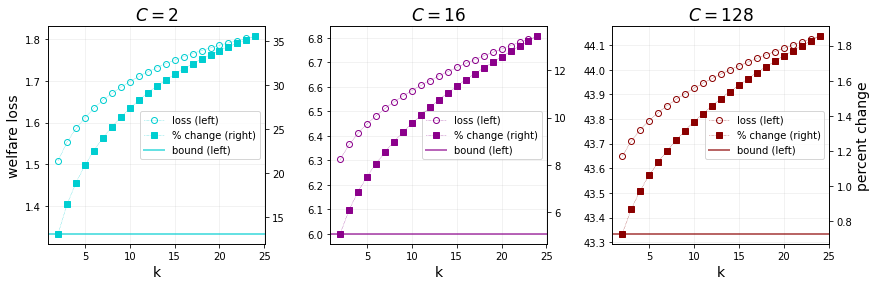

In [157]:
f, axarr = plt.subplots(ncols=3, figsize=(14, 4))

data = [
    (a3c2res, a3c2pdiff, a3c2res_honest, 'darkturquoise', (2+a-1)/a, r'$C=2$'),
    (a3c16res, a3c16pdiff, a3c16res_honest, 'darkmagenta', (16+a-1)/a, r'$C=16$'),
    (a3c128res, a3c128pdiff, a3c128res_honest, 'darkred', (128+a-1)/a, r'$C=128$')
]

for i, (res, pdiff, honest, color, hline_value, title) in enumerate(data):
    line1, = axarr[i].plot(ns, res, color=color, linewidth=0.5, label='loss (left)',
                           linestyle='dotted', marker='o', fillstyle='none')
    line2 = axarr[i].axhline(hline_value, color=color, label='bound (left)', alpha=0.6, linewidth=2)
    
    twinx = axarr[i].twinx()
    line3, = twinx.plot(ns, pdiff, color=color, linewidth=0.5, label='% change (right)',
                        linestyle='dotted', marker='s', fillstyle='full')
#     line4, = axarr[i].plot(ns, honest, color=color, linewidth=0.5, label='honest loss (left axis)',
#                            linestyle='-.', marker='*', fillstyle='none')

    lines = [line1, line3, line2]
    labels = [line.get_label() for line in lines]
    axarr[i].legend(lines, labels)
    axarr[i].set_title(title, size=17)

for ax in axarr:
    ax.set_xlabel('k', size=14)
    ax.grid(alpha=0.2)

axarr[0].set_ylabel('welfare loss', size=14)
twinx.set_ylabel('percent change', size=14)

f.subplots_adjust(wspace=0.3)
# plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# counter example for adding a max-coster maximally degrading welfare 

In [201]:
costs = [1]
guess = [200]

costs.extend([128]*1)
guess.extend([500]*1)

bids  = getEquilBids(costs, a=a, guess=guess)
allos = getAllos(bids, a=a)

print("costs={}\nbids={}\nallos={}\nw. loss={}".format(costs, bids, allos, np.dot(costs, allos)))
print()
print("costs={}; w. loss={}".format(costs, np.dot(costs, allos)))

costs=[1, 128]
bids=[204.19102779 256.63306468]
allos=[0.66502617 0.33497383]
w. loss=43.54167586667451

costs=[1, 128]; w. loss=43.54167586667451


In [202]:
costs = [1]
guess = [200]

costs.extend([128]*1)
guess.extend([500]*1)

costs.append(128)
guess.append(500)

bids  = getEquilBids(costs, a=a, guess=guess)
allos = getAllos(bids, a=a)
print("costs={}\nbids={}\nallos={}\nw. loss={}".format(costs, bids, allos, np.dot(costs, allos)))
print()
print("costs={}; w. loss={}".format(costs, np.dot(costs, allos)))

costs=[1, 128, 128]
bids=[135.02747054 213.54609094 213.54609094]
allos=[0.66417961 0.16791019 0.16791019]
w. loss=43.64918897930342

costs=[1, 128, 128]; w. loss=43.64918897930342


In [204]:
costs = [1]
guess = [170]

costs.extend([128]*1)
guess.extend([200]*1)

costs.append(80)
guess.append(100)

bids  = getEquilBids(costs, a=a, guess=guess)
allos = getAllos(bids, a=a)
print("costs={}\nbids={}\nallos={}\nw. loss={}".format(costs, bids, allos, np.dot(costs, allos)))
print()
print("costs={}; w. loss={}".format(costs, np.dot(costs, allos)))

costs=[1, 128, 80]
bids=[103.38458282 201.87396796 143.6156503 ]
allos=[0.66341097 0.08910643 0.24748261]
w. loss=31.867641994840255

costs=[1, 128, 80]; w. loss=31.867641994840255


In [220]:
otherCosts

array([  1,   8,  15,  22,  29,  36,  43,  50,  57,  64,  71,  78,  85,
        92,  99, 106, 113, 120, 127])

In [237]:
otherCosts = np.arange(1, 129, 3)
wWOther   = []
for oc in otherCosts:
    costs = [1]
    guess = [oc]

    costs.extend([128]*1)
    guess.extend([oc*2]*1)

    costs.append(oc)
    guess.append(oc*1.5)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    wWOther.append(np.dot(costs, allos))
len(wWOther)

43

In [236]:
otherCosts = np.arange(1, 129, 3)
wWOther_512   = []
for oc in otherCosts:
    costs = [1]
    guess = [oc]

    costs.extend([512]*1)
    guess.extend([oc*4]*1)

    costs.append(oc)
    guess.append(oc*1.5)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    wWOther_512.append(np.dot(costs, allos))
len(wWOther_512)

43

In [245]:
otherCosts = np.arange(1, 129, 3)
wWOther_64   = []
for oc in otherCosts:
    costs = [1]
    guess = [oc]

    costs.extend([64]*1)
    guess.extend([oc*1.5]*1)

    costs.append(oc)
    guess.append(oc*1.5)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    wWOther_64.append(np.dot(costs, allos))
len(wWOther_64)

43

In [246]:
otherCosts = np.arange(1, 129, 3)
wWOther_32   = []
for oc in otherCosts:
    costs = [1]
    guess = [oc]

    costs.extend([32]*1)
    guess.extend([oc*1.3]*1)

    costs.append(oc)
    guess.append(oc*1.4)
    bids  = getEquilBids(costs, a=a, guess=guess)
    allos = getAllos(bids, a=a)
    wWOther_32.append(np.dot(costs, allos))
len(wWOther_32)

43

In [248]:
wWOther_32

[1.00378025987167,
 2.219149171330619,
 3.4225835597303034,
 4.708153689279579,
 6.005400881195193,
 7.236565967605406,
 8.352517384199883,
 9.332202182918556,
 10.172900782160205,
 10.882004543932931,
 11.471737314023457,
 11.956063746027601,
 12.34897633431242,
 12.663610036168418,
 12.911840641235795,
 13.104157411027947,
 13.249684312453464,
 13.356275510331944,
 13.430642475141527,
 13.478489005566882,
 13.504641749339502,
 13.513170349624096,
 13.507494941915414,
 13.490480742540484,
 13.464520396967366,
 13.43160519294968,
 13.39338637670219,
 13.3512277779549,
 13.306250869416079,
 13.259373255056119,
 13.211341485030669,
 13.162758971652599,
 13.114109683840852,
 13.06577821101338,
 13.018066724777428,
 12.971209262124187,
 12.925383743745462,
 12.880722051707364,
 12.837318462743164,
 12.795236681353067,
 12.754515703443108,
 12.715174677438814,
 12.677216935441487]

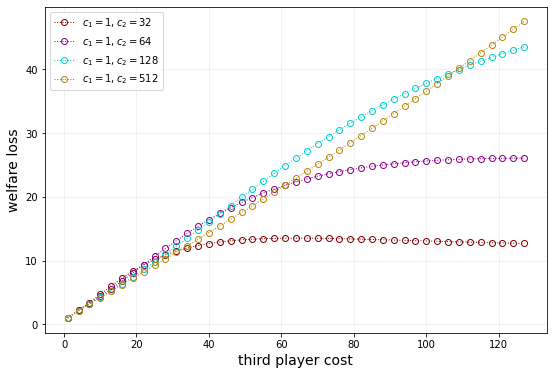

In [253]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(otherCosts, wWOther_32, color='maroon', linewidth=1, 
        linestyle='dotted', marker='o', fillstyle='none', label=r'$c_1=1,c_2=32$')
ax.plot(otherCosts, wWOther_64, color='darkmagenta', linewidth=1, 
        linestyle='dotted', marker='o', fillstyle='none', label=r'$c_1=1,c_2=64$')
ax.plot(otherCosts, wWOther, color='darkturquoise', linewidth=1, 
        linestyle='dotted', marker='o', fillstyle='none', label=r'$c_1=1,c_2=128$')
ax.plot(otherCosts, wWOther_512, color='darkgoldenrod', linewidth=1, 
        linestyle='dotted', marker='o', fillstyle='none', label=r'$c_1=1,c_2=512$')


ax.set_xlabel('third player cost', size=14)
ax.set_ylabel('welfare loss', size=14)
ax.legend()
ax.grid(alpha=0.2)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [42]:
a3res[2]

array([43.54167587,  1.02180144,  1.00484542,  1.00311307,  1.00273902,
        1.00609571,  1.0071116 ,  1.00812748,  1.00914334,  1.01015919,
        1.01117502,  1.01219083,  1.01320663,  1.01422241,  1.01523817,
        1.01625392,  1.01726965,  1.01828537,  1.01930107,  1.02031675,
        1.02133242,  1.02234807,  1.0233637 ,  1.02437932])

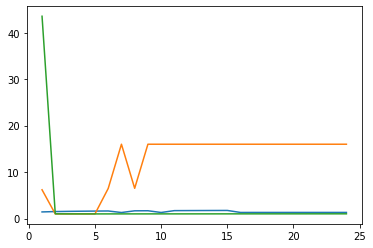

In [41]:
plt.plot(ns, a3res[0])
plt.plot(ns, a3res[1])
plt.plot(ns, a3res[2])

In [ ]:
a     = 3
Cs    = [2, 16, 128]
ns    = np.arange(1, 25)

a3res     = []
lbs       = []
initials  = [8, 16, 50]
for i,C in enumerate(Cs):
    temp = []
    lbs.append((C+a-1)/a)
    for n in tqdm(ns):
        costs = [1]
        costs.extend([C]*n)
        guess = [1]
        guess.extend([initials[i]]*n)
        bids  = getEquilBids(costs, a=a, guess=guess)
        allos = getAllos(bids, a=a)
        temp.append(np.dot(costs, allos))
    a3res.append(temp)
a3res = np.array(a3res)
a3res.shape